In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123

/home/alex/NuMI/PELEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() # the default option is FHC, RHC needs different arguments

In [5]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 11212022


In [6]:
SHRCALIBFACTOR = 1.00

In [7]:
# USING BDT?
USEBDT = True

In [8]:
# Doing Run3?
ISRUN3 = False

In [9]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [10]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)



In [12]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265


angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [13]:
tree = "NeutrinoSelectionFilter"


#new
#BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
#This is with the new GENIE tune
#NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune

DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND

mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]
#nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]


uproot_v = [mc,ext,data,dirt] 


variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        #"trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
        #"trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
        #"trk_start_x_v","trk_start_z_v","trk_start_z_v",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
    ]

varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x"]

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


['ccnc', 'theta', 'reco_nu_vtx_sce_x', 'slnunhits', 'CosmicDirAll3D', 'reco_nu_vtx_sce_y', 'slnhits', 'mc_pdg', 'muon_e', 'pi0_e', 'backtracked_pdg', 'CosmicIPAll3D', 'true_e_visible', 'reco_nu_vtx_z', 'isVtxInFiducial', 'npi0', 'reco_nu_vtx_x', 'sub', 'reco_nu_vtx_y', 'evt', 'nslice', 'interaction', 'CosmicIP', 'category', 'reco_nu_vtx_sce_z', '_opfilter_pe_beam', 'pion_e', '_opfilter_pe_veto', 'flash_pe', 'nu_pdg', 'npion', 'run', 'nproton', 'pi0truth_elec_etot', 'slpdg', 'reco_e', 'topological_score', 'trk_llr_pid_score_v', 'evnunhits', 'slclustfrac']


In [14]:
import pandas as pandas    
#dirt = dirt.pandas.df(variables + varMC + WEIGHTS + SYSTEMATICS, flatten=False)
#mc   =   mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
#data = data.pandas.df(variables, flatten=False)
#ext  =  ext.pandas.df(variables, flatten=False)

dirt_var = variables + varMC + WEIGHTS + SYSTEMATICS
mc_var   = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC
data_var = variables
ext_var  = variables
#nue_var  = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC


# This needs modifications (add variables from above)
uproot_v = [mc,ext,data,dirt] 
var_v    = [mc_var,ext_var,data_var,dirt_var] 

#nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        mc = CVDF
    elif ii == 1:
        ext = CVDF
    elif ii == 2:
        data = CVDF
    else:
        dirt =  CVDF

trk_llr_pid_v  [[0.82782626 -0.8194372 0.3865043 0.09241907] [0.66136134 0.26579022 -0.4465902] [0.9429299] ... [-0.7478028 -0.31272712 -0.07394644 0.6294419 -0.15682676 0.044288084] [0.9825717 0.8653566 0.30652303 0.37347093 0.0450483] [0.8391653 0.832069 0.35647532 0.38325506]]
trk_score_v  [[0.013178393 0.9346445 0.9606818 0.16331574] [0.9108349 0.45338693 0.94899696] [0.0006027788] ... [0.9460351 0.1035448 0.72438586 0.5656786 0.97891515 0.51936793] [1.0 0.0056803394 0.08460715 0.59094507 0.8683876] [0.034102786 0.08651647 0.49835193 0.06482802]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


trk_llr_pid_v  [[0.4775138] [0.9612796] [0.46180135 0.54934144 0.10673018] ... [0.73604786 0.15185338] [0.513903 0.09590046 0.101642326] [0.547429 0.42826256]]
trk_score_v  [[0.29486892] [0.00014609084] [1.0961453e-07 0.2947586 0.73173183] ... [0.13884807 0.712718] [0.3139902 0.7329207 0.863878] [0.85589015 0.32862234]]
trk_llr_pid_v  [[0.61479425] [0.6336193 0.39911884 0.021630378] [0.7970757 -0.21337485 -0.3697966] ... [0.4188579] [0.6745422] [0.8221383 0.5234873 0.25720716 0.038982317]]
trk_score_v  [[0.35534355] [0.34817457 0.14082558 0.3428277] [0.0009466654 0.9058201 0.9391397] ... [0.27186927] [0.42120844] [0.82834244 0.8871221 0.7718351 0.0036477235]]
trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]


# Weights

In [15]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [16]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    '''
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    '''


In [17]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']


In [18]:
df_v = [mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
    
    # Cray cray weight fix
    #for ievt in range(df.shape[0]):
    #    reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
    #                         (df['weightsGenie'].iloc[ievt] == np.inf))
    #    df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [19]:
df_v = [mc,dirt,data,ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

# Adding variables

In [20]:
df_v = [mc,dirt,data,ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])    
    #df['muon_Angle_Numi_Theta']   = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['muon_theta'],x['muon_phi']) , axis=1)
    #df['cosMu_Angle_Numi_target'] = np.cos(df['muon_Angle_Numi_Theta'])
    #df['Q2reco']  = 2 * df['neutrino_energy'] * ( df['muon_energy'] - df['muon_momentum'] *df['cosMu_Angle_Numi_target'] ) - 0.105**2
    #df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    #df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

data["bnbdata"] = np.ones_like(data["isVtxInFiducial"])
ext["extdata"] = np.ones_like(ext["isVtxInFiducial"])

In [21]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)
    '''    
    print(len(listPx), df.shape)
    df['shr_p']       = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    ##########################################
    df['dir_mu_px']  = df['shr_px']/df['shr_p']
    df['dir_mu_py']  = df['shr_py']/df['shr_p']
    df['dir_mu_pz']  = df['shr_pz']/df['shr_p']
    
    df['nu_reco_px']  = listPx
    df['nu_reco_py']  = listPy
    df['nu_reco_pz']  = listPz
    df['BNBP']     = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'] + df['nu_reco_pz']*df['nu_reco_pz'])
    df['BNBPt']    = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'])
    df['BNBTheta'] = np.arccos(df['nu_reco_pz']/df['BNBP'] )
    df['BNBPhi']   = np.arctan2(df['nu_reco_py'],df['nu_reco_px'])
    df['nu_Angle_Numi_Theta'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['BNBTheta'],x['BNBPhi']) , axis=1)
    df['cosNu_Angle_Numi_Theta'] = np.cos(df['nu_Angle_Numi_Theta'])
    df['NuMIPt'] = df['BNBP'] * (np.sin(df['nu_Angle_Numi_Theta']))
    df['checkPt']  = df['BNBPt'] - df['pt']
    '''   

/tmp/ipykernel_14651/231876075.py:8: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


# Event Categories

In [22]:
data["is_signal"] = data["category"] == 11
mc["is_signal"]   = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"]  = ext["category"] == 11
#nue["is_signal"]  = nue["category"] == 11

In [ ]:
mc   = mc.query('nu_e > 0.')
dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [mc,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

# Selection

In [22]:
# numu selection                                                                                                                                                                                                              
#NUMUPRESEL = 'nslice == 1'
#NUMUPRESEL += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
#NUMUPRESEL += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251. '
#NUMUPRESEL += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110. '
#NUMUPRESEL += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986. '

#NUMUPRESEL2 = NUMUPRESEL + ' and topological_score > 0.06 '

#NUMUSEL = NUMUPRESEL2 + ' and n_muons_tot > 0'


## Get MC Number

In [20]:
#THESE NEED WEIGHTS

truthsel  = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)")
print(truthsel.size)

truthbin1 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 0.04 and nu_e < 0.5)")
truthbin2 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 0.5 and nu_e < 1.0)")
truthbin3 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 1.0 and nu_e < 1.5)")
truthbin4 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 1.5 and nu_e < 2.0)")
truthbin5 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 2.0 and nu_e < 2.5)")
truthbin6 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 2.5 and nu_e < 3.0)")
truthbin7 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 3.0 and nu_e < 3.5)")
truthbin8 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 3.5 and nu_e < 4.0)")
truthbin9 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 4.0 and nu_e < 4.5)")
truthbin10 = mc.query("(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton >0 and nu_e >= 4.5 and nu_e < 5.0)")

ratiotruths = [truthbin1.size, truthbin2.size, truthbin3.size, truthbin4.size, truthbin5.size, truthbin6.size, truthbin7.size, truthbin8.size, truthbin9.size, truthbin10.size]
print(ratiotruths)

21175180
[2407340, 4994210, 5023720, 4070430, 2104960, 1013480, 647920, 443430, 278330, 191360]


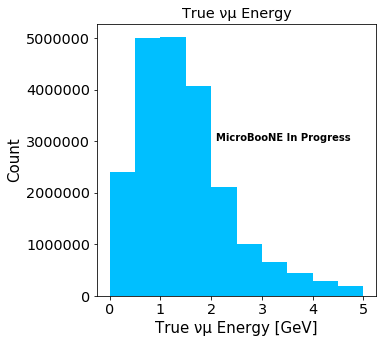

In [25]:
#THESE NEED WEIGHTS

import matplotlib.pyplot as plt
import matplotlib

nue_truth = [2407340, 4994210, 5023720, 4070430, 2104960, 1013480, 647920, 443430, 278330, 191360]
count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
weights = [0.1*nue_truth[0], 0.6*nue_truth[1], 1.1*nue_truth[2], 1.6*nue_truth[3], 2.1*nue_truth[4], 2.6*nue_truth[5], 3.1*nue_truth[6], 3.6*nue_truth[7], 4.1*nue_truth[8], 4.6*nue_truth[9]]
bins = np.arange(0, 5.5, 0.5)    
    
# plot selected signal events 
fig, ax1 = plt.subplots(figsize=(5, 5))
    
sel = ax1.hist(count, bins, color='deepskyblue', weights=nue_truth)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('True νμ Energy [GeV]', fontsize=15)
#ax1.set_ylim(0, 3500)
ax1.set_title("True νμ Energy")
    
plt.text(2.1, 3000000, r'MicroBooNE In Progress', fontweight='bold')
plt.show()

# Plotting part

In [23]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/home/alex/NuMI/PELEE/plotter.py'>

In [24]:
# muon selection
#QUERY = NUMUPRESEL #NUMUSEL #'nslice == 1'


In [24]:
import plotter
import importlib
importlib.reload(plotter)

#nue = mc.query("(abs(nu_pdg) == 12 and ccnc == 0)") 
#nueMC = mc.query("(abs(nu_pdg) == 14 & ccnc == 0)")
##CHANGE
nue   = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "mc"  : mc,
    "nue" : nue,
    "data": data,
    "dirt": dirt,
    "ext" : ext
}

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
nueratio  = pot/2.37838e+22    
dirtratio = pot/1.42143e+21
extratio  = 5268051.0/9199232.74

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98
scalingDRT = 0.60 #0.35

weights = { "mc"  : mcratio  * SPLIT * scaling,
            "nue"  : mcratio  * SPLIT * scaling, #needed as the plotter needs nue but we're not using
            #"nue" : nueratio  * SPLIT * scaling,
            "ext" : extratio * SPLIT * scalingEXT,    
            "dirt": dirtratio* SPLIT * scalingDRT,   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 0.08559738414394057, 'nue': 0.08559738414394057, 'ext': 0.5612087579382191, 'dirt': 0.08442202570650682}


In [25]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['neutrino_energy'], bins, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['neutrino_energy'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True νμ Energy [GeV]', fontsize=15)

    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected['neutrino_energy'], bins, color='white')
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['neutrino_energy'], bins, color='deepskyblue')
    ax1.set_ylim(0, 20000)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True νμ Energy and Efficiency")
    plt.text(2, 0.85, r'MicroBooNE In Progress')

    plt.show()

true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 14 and ccnc == 0) and nproton > 0& nu_e <= 5 & nu_e >= 0.04 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  9.701832553168252  c  31
order w sum  56.61988205835373  c  3
order w sum  1263.5695172095354  c  5
order w sum  1517.2451182050568  c  21
order w sum  3201.6912430494294  c  0
order w sum  8508.344111589377  c  2

SUMS
[9.701832553168257, 66.32171461152197, 1329.8912318210555, 2847.1363500261054, 6048.8275930755335, 14557.171704664883]
[56.61988205835371, 1263.5695172095336, 1517.24511820505, 3201.691243049428, 8508.34411158935]

Nue Wanted List:
[742.1372399702764, 769.7020293421637, 696.5629183035333, 479.27029691102337, 232.51431248133855, 110.0945798017724, 68.16526468733355, 50.43833291526654, 31.97971027539188, 20.826558361327898]

labels  ['$\\nu$ NC $\\pi^{0}$: 9.7', '$\\nu$ NC: 56.6', 'Out.

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/NuMI/PELEE/plotter.py:458: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc

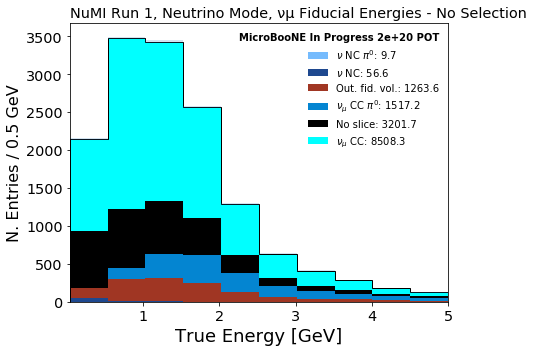

In [26]:
#Preselection Plot

import matplotlib.pyplot as plt
import matplotlib

systematicsBool = False

#why is this not just nu_e?
VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.04, 5.0),"True Energy [GeV]"

#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 14 and ccnc == 0) and nproton > 0"
FID_QUERY = fiduc

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= FID_QUERY,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    ratio = False,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]


ax1.set_title('NuMI Run 1, Neutrino Mode, νμ Fiducial Energies - No Selection',loc='left')
#ax2.set_ylim(0.95,1.05)

fig.tight_layout()

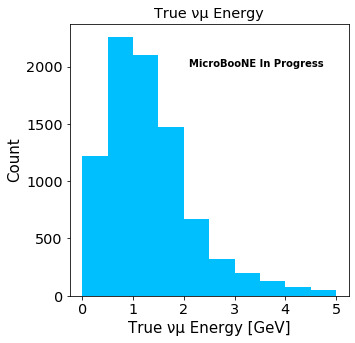

In [27]:
import matplotlib.pyplot as plt
import matplotlib

nue_truth = [1220.0367213238023, 2258.2406838876914, 2100.1833549260464, 1469.8593893372008, 673.8832816172271, 320.2300722027785, 201.54109350329145, 129.43528649905602, 81.12543212207311, 53.80879617018218]
count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
weights = [0.1*nue_truth[0], 0.6*nue_truth[1], 1.1*nue_truth[2], 1.6*nue_truth[3], 2.1*nue_truth[4], 2.6*nue_truth[5], 3.1*nue_truth[6], 3.6*nue_truth[7], 4.1*nue_truth[8], 4.6*nue_truth[9]]
bins = np.arange(0, 5.5, 0.5)    
    
# plot selected signal events 
fig, ax1 = plt.subplots(figsize=(5, 5))
    
sel = ax1.hist(count, bins, color='deepskyblue', weights=nue_truth)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('True νμ Energy [GeV]', fontsize=15)
#ax1.set_ylim(0, 3500)
ax1.set_title("True νμ Energy")
    
plt.text(2.1, 2000, r'MicroBooNE In Progress', fontweight='bold')
plt.show()

nslice >= 0
nslice >= 0& nslice <= 2 & nslice >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  79463.55492388699  c  0
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
total  630496.4303824427


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


IndexError: index 2 is out of bounds for axis 0 with size 2

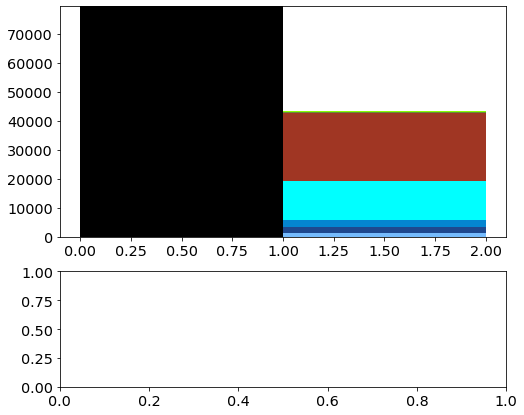

In [28]:
import matplotlib.pyplot as plt
import matplotlib

#SEL_QUERY = 'nslice == 1'
SEL_QUERY = 'nslice >= 0'
print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'nslice',2,(0.0,2.0),"SliceID"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, νμ - SliceID',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

#610496

130764 signal events were selected
165854  events were generated
efficiency =  0.7884283767651067
purity =  0.3240109061732062
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  1.0  with error =  0.0
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  1.0  with error =  0.0
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  1.0  with error =  0.0
In bin 8 , eff =  1.0  with error =  0.0


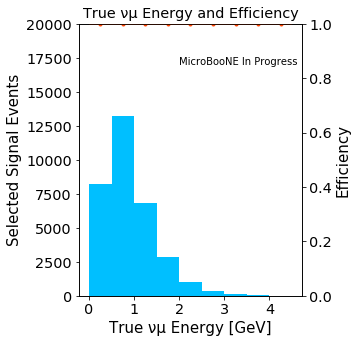

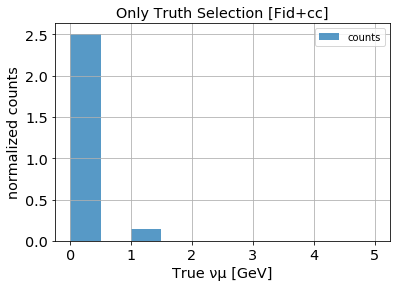

In [28]:
import matplotlib.pyplot as plt
import matplotlib
###########################################
#check the efficiency

#store efficiencies after each selection
effs = []
purs = []

effs.append(1.0)

purs.append(0.0)

#(nue.query(fiduc_q)).info()

SEL_QUERY = 'nslice == 1'
#SEL_QUERY = 'nslice == 1 and n_showers > 0 and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8 and contained_fraction > 0.85 and (topological_score > 0.2 or topological_score < 0.01) and CosmicIPAll3D > 15 and shr_score < 0.15 and hits_ratio > 0.5 and shrmoliereavg < 7 and ((n_tracks > 0 and (((shr_tkfit_dedx_max > 0 and shr_tkfit_dedx_max < 1.75) and shr_distance <= 3)  or ((shr_tkfit_dedx_max >= 1.75 and shr_tkfit_dedx_max < 2.5) and shr_distance <= 12)  or ((shr_tkfit_dedx_max >= 2.5 and shr_tkfit_dedx_max < 3.5) and shr_distance <= 3) or ((shr_tkfit_dedx_max >= 3.5 and shr_tkfit_dedx_max < 4.7) and shr_distance <= 0) or ((shr_tkfit_dedx_max >= 4.7) and shr_distance <= 3))) or (n_tracks == 0 and ((shr_tkfit_dedx_max >= 1.7 and shr_tkfit_dedx_max < 2.7) or (shr_tkfit_dedx_max >= 5.5))))'

#selected = fullnue.query(SEL_QUERY)
selected = mc.query(SEL_QUERY)

#This will get how many true numuCC's in the fiducial vol there are
fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 14 and ccnc == 0) and nproton > 0"

#sel_fid = SEL_QUERY + ' and ' + fiduc_q
selected_fid = selected.query(fiduc_q)

#numuonly = "abs(nu_pdg) == 14"
#numucconly = "(abs(nu_pdg) == 14 and ccnc == 0)"

print(str(len(selected.query(fiduc_q)))+' signal events were selected')
print(str(len(mc.query(fiduc_q)))+'  events were generated')
selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC                      #Selection eff = number of selected neutrino interactions
                                        #classified as either ν mu / ̄ν mu CC
                                        #divided by the total number 
                                        #of true simulated ν mu and ν mu CC interactions
                                        #in the fiducial volume
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY))* 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)              #Selection purity = number of selected neutrino interactions
                                    # classified as ν mu / ̄ν mu CC
                                    # divided by the total
                                    #number of selected events regardless their 
                                    #classification (but excluding the beam-on data)
purs.append(pur)


bins = np.arange(0, 5.0, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

####################################
#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"

#just look for muon neutrinos
q2 = "((nu_pdg) == 14 and ccnc == 0) and nproton > 0 +" + fiduc
#in the mc data
nueMCSel  = mc.query(q2)

fig, ax = plt.subplots(nrows=1, sharex=True)

#n1, bins1, patches1 = ax[0].hist('elec_e',25,weights='weightSplineTimesTuneTimesPPFX',  range=(0,5), alpha=0.75, label='Elec')
n2, bins2, patches2 = ax.hist(nueMCSel['neutrino_energy'],10,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='counts')

ax.set_xlabel('True νμ [GeV]')
ax.set_ylabel('normalized counts')
ax.set_title('Only Truth Selection [Fid+cc]')
ax.legend()
ax.grid(True)

nslice == 1
nslice == 1 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  400.85453759169735  c  3
order w sum  551.0037370763533  c  21
order w sum  735.4634627017481  c  31
order w sum  1038.9194455782722  c  2
order w sum  12396.990121440069  c  5
order w sum  152.1773387479329  c  1
order w sum  0  c  12
order w sum  84.92697370696374  c  10
order w sum  259.97535114064254  c  11
total  19036.388677553958
[0.    0.    0.    0.    0.    0.    0.    0.    4.525 0.    0.    0.
 0.    0.    0.    0.    0.    2.373 1.202 1.751 2.178 1.772 1.293 2.211
 0.914 3.382 1.09  1.423 1.8   1.063]
sum:  26.977671970664062
[0.    0.    0.    0.    0.    0.    0.    0.    4.525 0.    0.    0.
 0.    0.    0.    0.    0.    3.861 2.544 2.4   3.696 2.435 1.804 2.365
 1.192 3.674 1.382 1.737 1.887 1.474]
sum:  34.97662789891462
[0.    0.    0.    0.    0.    0.    0.    0.    4.856 0.    0.    0.
 0.    0.    0.    0.    0.    6.267 4.696 3.832 4.853 2.992 2.428 2.829
 2.195 4.456 2.323 2

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[2995 1010 1303 ...  189  954  637]
[ 385 1019 2720 ...  848  989  541]
[1230 1014 2040 ... 1416 1171  710]
[ 571  999 1088 ...  292  969  640]
[1509 1036 1319 ...  437 1053  760]
[2328 1019 1137 ...   38 1138  840]
[2447 1023 1031 ...  377 1107  515]
[1642 1027 1587 ...  503 1131  648]
[1481 1027  720 ...  798 1003  436]
[1095 1002 3798 ...  324 1007  606]
nue
var_name =  _opfilter_pe_beam
name =  weightsPPFX
entry
2        [1008, 1023, 1024, 1008, 1048, 1031, 1029, 103...
4        [1415, 897, 762, 1119, 1301, 587, 869, 2046, 3...
6        [1010, 1022, 1020, 1003, 1045, 1026, 1027, 103...
10       [1210, 1036, 927, 978, 1009, 1067, 1180, 1054,...
18       [639, 1656, 1302, 1111, 558, 160, 560, 777, 84...
                               ...                        
46772    [1044, 424, 1194, 1031, 977, 782, 914, 699, 11...
46794    [582, 775, 876, 521, 586, 367, 257, 288, 406, ...
46798    [865, 855, 1319, 1139, 1099, 766, 998, 490, 75...
46808    [780, 539, 517, 263, 450, 463, 1814, 167

KeyError: 'weightsNuMIGeo'

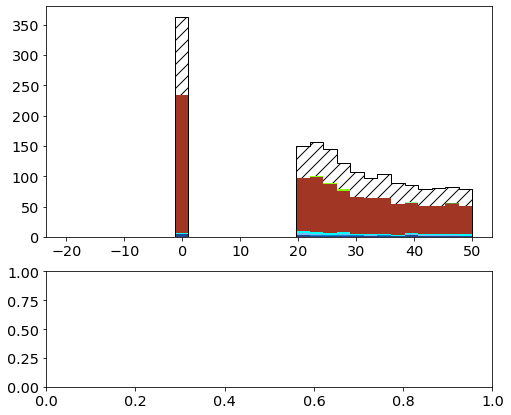

In [32]:
#_opfilter_pe_beam

import matplotlib.pyplot as plt
import matplotlib

#SEL_QUERY = 'nslice >= 0'
print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = '_opfilter_pe_beam',30,(-20.0,50.0),"OpFilter PE Beam"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - OpFilter PE Beam',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

nslice == 1
nslice == 1 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
total  98838.35754609265


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.160e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 2.336e+00 2.722e+00 1.900e+00 9.875e-01
 1.051e+00 1.442e+00 3.668e-01 2.317e-01 5.109e-01 4.566e-01 1.847e-01
 1.501e-01 2.792e-01]
sum:  1172.8756628411252
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 3.462e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 7.136e+00 6.394e+00 4.248e+00 3.109e+00
 3.527e+00 3.646e+00 1.224e+00 1.612e+00 1.127e+00 1.003e+00 8.384e-01
 7.095e-01 4.714e-01]
sum:  3496.816472069635
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 5.832e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.185e+01 1.029e+01 6.650e+00 6.157e+00
 4.941e+00 4.999e+00 2.443e+00 2.704e+00 2.318e+00 1.752e+00 1.547e+00
 1.689e+00 1.007e+00]
sum:  5890.520859976767
[0.000e+0

/home/alex/NuMI/PELEE/plotter.py:257: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/alex/NuMI/PELEE/plotter.py:2281: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


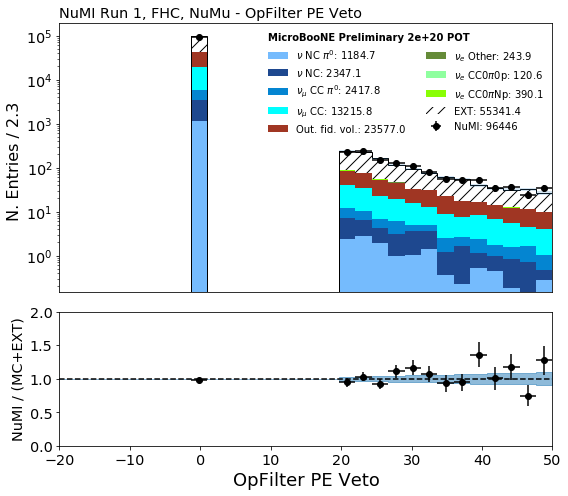

In [37]:
#_opfilter_pe_veto

import matplotlib.pyplot as plt
import matplotlib

#SEL_QUERY = 'nslice >= 0'
print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = '_opfilter_pe_veto',30,(-20.0,50.0),"OpFilter PE Veto"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - OpFilter PE Veto',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

nslice == 1
nslice == 1& bnbdata <= 2 & bnbdata >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
total  98838.35754609265
[1184.653    0.   ]
sum:  1184.6528973373538


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


IndexError: index 2 is out of bounds for axis 0 with size 2

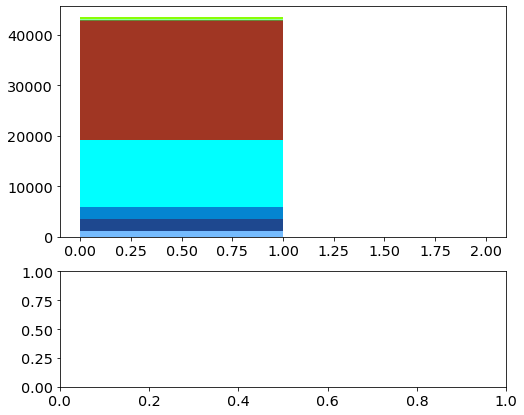

In [38]:
#bnbdata

import matplotlib.pyplot as plt
import matplotlib

print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'bnbdata',2,(0.0,2.0),"bnb data"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - bnbdata',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

nslice == 1
nslice == 1& extdata <= 2 & extdata >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1184.6528973373554  c  31
order w sum  2347.1468964318847  c  3
order w sum  2417.7970251854567  c  21
order w sum  13215.808157724492  c  2
order w sum  23576.997310890878  c  5
order w sum  243.94473084531342  c  1
order w sum  0  c  12
order w sum  120.5903182191437  c  10
order w sum  390.0633804915802  c  11
total  98838.35754609265
[1184.653    0.   ]
sum:  1184.6528973373538


IndexError: index 2 is out of bounds for axis 0 with size 2

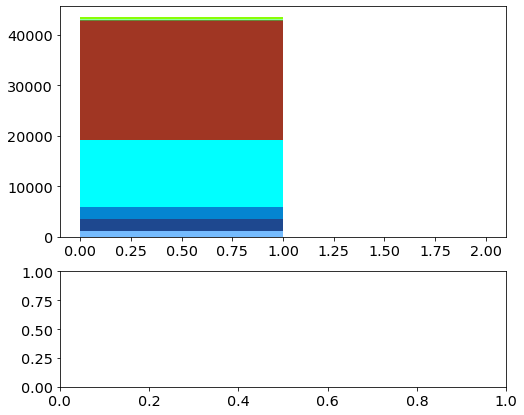

In [39]:
#ext data

import matplotlib.pyplot as plt
import matplotlib

print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'extdata',2,(0.0,2.0),"ext data"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - ext data',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.7722394395070363
purity =  0.31952785765532976
In bin 0 , eff =  0.9814637875023887  with error =  0.0010764940784094778
In bin 1 , eff =  0.9798919090764584  with error =  0.0012514101282507482
In bin 2 , eff =  0.9817195087117966  with error =  0.002264079054178968
In bin 3 , eff =  0.9785522788203753  with error =  0.0053041180364447535
In bin 4 , eff =  0.9947089947089947  with error =  0.0052769893583287444
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  0.9411764705882353  with error =  0.05706720589090188


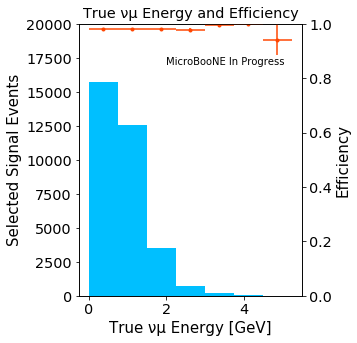

In [29]:
#SEL_QUERY_B = SEL_QUERY
SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 6.0, 0.75)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1158.9407829307493  c  31
order w sum  2282.585270359426  c  3
order w sum  2369.6220300715327  c  21
order w sum  12937.53621575342  c  2
order w sum  22752.256528479313  c  5
order w sum  237.74894024145428  c  1
order w sum  0  c  12
order w sum  119.40726977830536  c  10
order w sum  381.07607475966927  c  11
total  97580.52994134043
[16.225 81.553 92.111 88.022 87.993 93.854 90.605 89.404 90.158 84.924
 82.313 88.858 85.866 78.144  6.799]
sum:  1156.8303578609712
[ 56.507 228.767 258.29  262.145 250.121 268.492 273.071 261.119 261.49
 263.587 264.406 261.645 259.758 225.199  38.78 ]
sum:  3433.377774146523
[ 91.935 409.066 445.683 450.189 436.074 456.003 454.422 446.98  442.363
 441.416 431.832 438.592 428.614 379.342 

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


n_ext  [4245.544 3149.504 3143.891 3368.936 3527.197 3615.307 3698.366 3749.436
 3804.434 3794.332 3724.181 3677.04  3613.062 3760.66  4264.064]
n_tot  [10981.798  6222.451  6016.605  6204.525  6290.542  6378.463  6447.698
  6466.253  6499.667  6428.007  6307.146  6178.272  5891.35   5794.652
  5181.932]
total array  [156.302 186.666 163.551 ... 226.594 163.076  11.381]
n_data  [11178  6004  6037  6188  6382  6242  6493  6296  6191  6360  6007  6102
  5839  5716  5107]
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1158.9407829307493  c  31
order w sum  2282.585270359426  c  3
order w sum  2369.6220300715327  c  21
order w sum  12937.53621575342  c  2
order w sum  22752.256528479313  c  5
order w sum  237.74894024145428  c  1
order w sum  0  c  12
order w sum  119.40726977830536  c  10
order w sum  381.07607475966927  c  11
total  97580.52994134043


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[ 6.027 31.766 41.203 44.248 43.125 43.852 43.212 43.499 43.006 41.797
 39.02  39.615 40.629 42.28  46.219 36.807 38.59  40.93  39.084 40.637
 40.773 40.482 39.312 37.316 40.91  40.698 38.63  34.051 28.42  20.948]
sum:  1147.0881613891418
[ 32.935  90.308 115.492 118.841 125.107 126.334 123.117 124.069 123.175
 121.917 112.931 118.8   117.474 115.18  122.382 113.705 117.221 119.437
 113.06  118.523 116.939 124.744 119.074 117.171 117.327 120.737 112.69
 104.59   94.88   94.606]
sum:  3392.7629008159747
[ 42.482 149.906 201.771 209.256 212.979 215.011 209.604 211.518 211.795
 209.643 200.684 203.706 203.235 204.656 204.283 201.008 195.774 203.653
 195.642 205.072 200.319 210.572 202.776 196.542 197.692 200.25  192.906
 179.803 159.47  116.548]
sum:  5748.55884858891
[127.087 446.881 651.228 677.444 691.174 694.592 681.133 693.912 683.362
 687.244 670.085 674.674 682.118 687.088 684.615 666.864 664.021 657.236
 652.344 686.377 656.068 660.064 661.39  644.558 654.859 635.477 616.487
 566.

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[14.928 34.18  31.67  37.253 36.946 41.671 38.797 38.615 39.748 44.167
 46.386 39.805 44.507 42.902 47.52  45.686 48.152 48.488 47.951 43.414
 23.623 44.582 49.008 44.855 44.684 46.074 41.7   38.804 11.937  0.887]
sum:  1158.9407829307472
[ 54.199  85.853  95.264 103.118 112.462 124.194 119.417 121.98  125.876
 130.902 140.261 126.189 127.54  132.809 137.123 139.801 139.099 140.094
 142.495 138.459  70.347 136.31  142.384 128.96  130.527 125.359 123.126
 105.834  36.576   4.965]
sum:  3441.5260532901793
[ 75.643 160.682 172.976 179.384 196.136 209.365 205.891 204.684 212.292
 221.368 228.698 215.204 215.602 215.381 224.511 232.151 238.376 232.8
 234.081 228.843 132.107 228.866 233.021 216.913 217.457 219.399 213.152
 185.268  54.81    6.086]
sum:  5811.14808336173
[198.332 554.484 579.603 619.353 639.951 678.143 676.284 658.767 708.799
 698.011 713.477 674.641 709.174 717.991 724.563 728.095 743.206 739.651
 747.269 716.194 465.348 750.259 725.5   708.223 700.406 712.775 665.788
 608.4

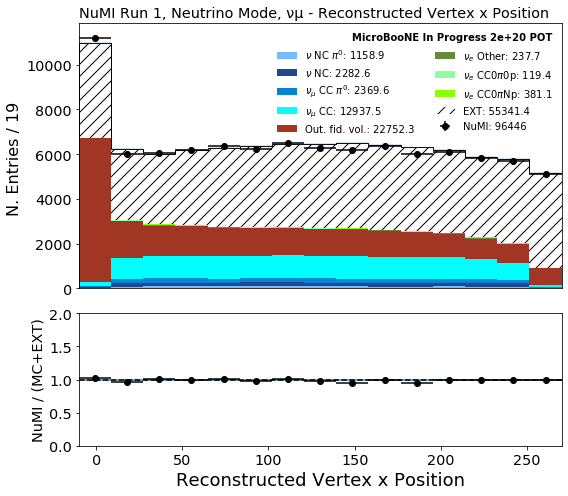

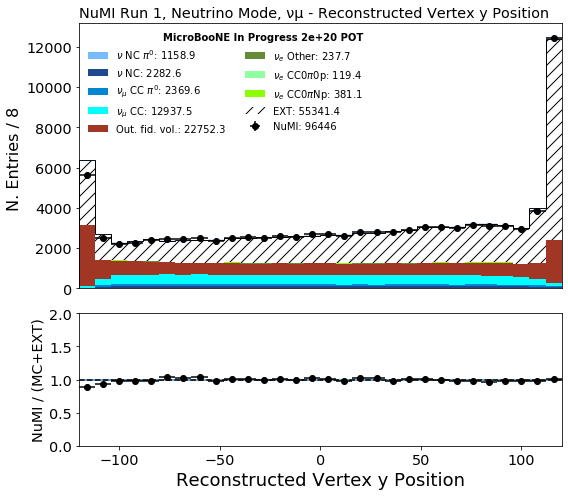

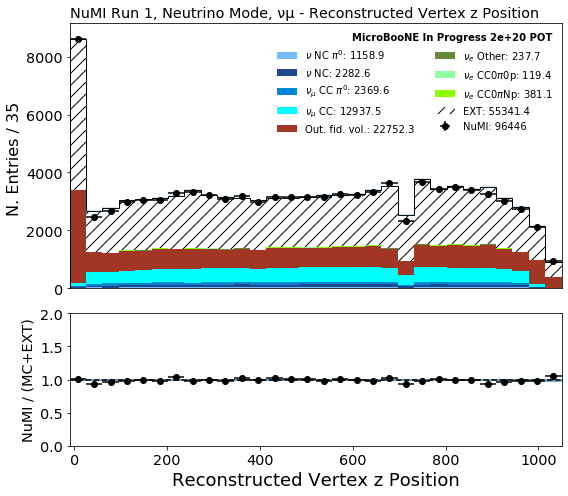

In [35]:
#reco_nu_vtx_sce_x

import matplotlib.pyplot as plt
import matplotlib

print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',15,(-10.0,270.0),"Reconstructed Vertex x Position"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, νμ - Reconstructed Vertex x Position',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

################################################################

#reco_nu_vtx_sce_y

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',30,(-120.0,120.0),"Reconstructed Vertex y Position"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, νμ - Reconstructed Vertex y Position',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

################################################################

#reco_nu_vtx_sce_z

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',30,(-10.0,1050.0),"Reconstructed Vertex z Position"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, νμ - Reconstructed Vertex z Position',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.7523966862421165
purity =  0.35122389137114673
In bin 0 , eff =  0.9798976608187134  with error =  0.0015491553985701341
In bin 1 , eff =  0.981237706158269  with error =  0.0011801771645704757
In bin 2 , eff =  0.9808898614150255  with error =  0.0016536298815940885
In bin 3 , eff =  0.9811188811188811  with error =  0.0025450227189910105
In bin 4 , eff =  0.9824902723735408  with error =  0.004090790770656254
In bin 5 , eff =  0.9777158774373259  with error =  0.007790348368331193
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  0.9824561403508771  with error =  0.017389285185380802
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  1.0  with error =  0.0


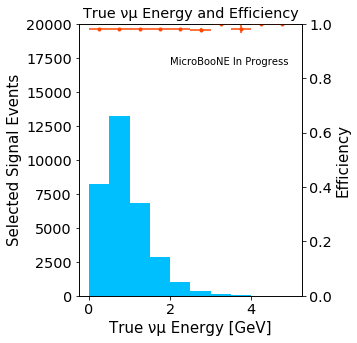

In [30]:
#SEL_QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251 '
SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
#SEL_QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 '
SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
#SEL_QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986 '
SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)


print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 & n_muons_tot <= 5 & n_muons_tot >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1125.9087160488093  c  31
order w sum  2169.132649711824  c  3
order w sum  2331.7226869670844  c  21
order w sum  12629.350015575179  c  2
order w sum  19767.21964622172  c  5
order w sum  232.8478953660204  c  1
order w sum  0  c  12
order w sum  114.1516599801091  c  10
order w sum  373.59179002497785  c  11
total  82265.66423797904
[1.016e+03 1.036e+02 5.545e+00 2.655e-01 0.000e+00]
sum:  1125.9087160488064


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


IndexError: index 5 is out of bounds for axis 0 with size 5

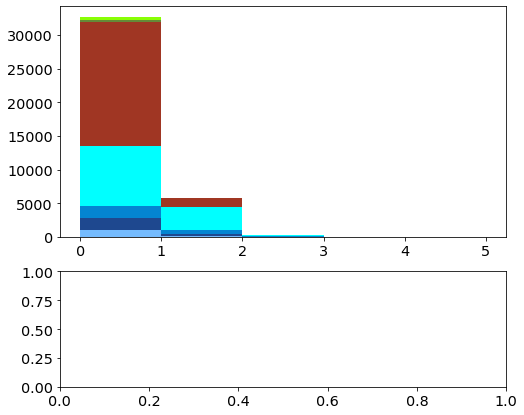

In [43]:
#n_muons_tot

import matplotlib.pyplot as plt
import matplotlib

#print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0.0,5.0),"n muons tot"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - n muons tot',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.20268428859117055
purity =  0.5034134665664991
In bin 0 , eff =  0.9798976608187134  with error =  0.0015491553985701341
In bin 1 , eff =  0.981237706158269  with error =  0.0011801771645704757
In bin 2 , eff =  0.9808898614150255  with error =  0.0016536298815940885
In bin 3 , eff =  0.9811188811188811  with error =  0.0025450227189910105
In bin 4 , eff =  0.9824902723735408  with error =  0.004090790770656254
In bin 5 , eff =  0.9777158774373259  with error =  0.007790348368331193
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  0.9824561403508771  with error =  0.017389285185380802
In bin 8 , eff =  1.0  with error =  0.0
In bin 9 , eff =  1.0  with error =  0.0


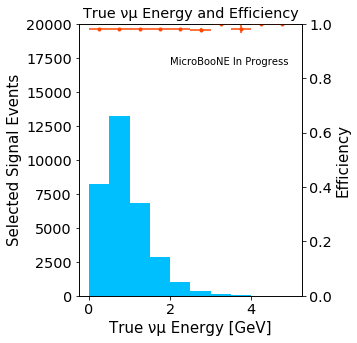

In [31]:
SEL_QUERY += ' and n_muons_tot > 0'
#see what happens i tn_muons_tot == 1

selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0& n_protons_tot <= 8 & n_protons_tot >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  109.41496775562655  c  31
order w sum  360.63953132963456  c  3
order w sum  600.9304958913716  c  21
order w sum  1315.1153610388258  c  5
order w sum  3675.939223341625  c  2
order w sum  39.52428904533051  c  1
order w sum  0  c  12
order w sum  5.287420718734101  c  10
order w sum  25.311145060953702  c  11
total  10929.374897038786


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


IndexError: index 8 is out of bounds for axis 0 with size 8

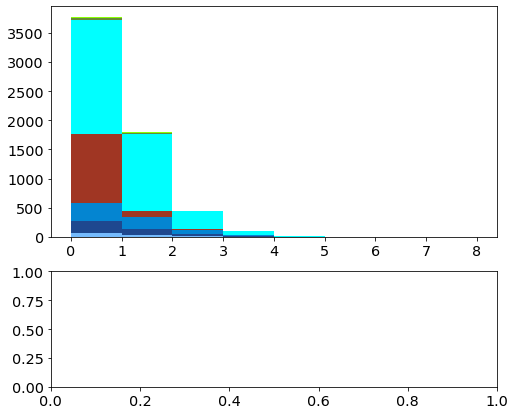

In [32]:
#n_protons_tot

import matplotlib.pyplot as plt
import matplotlib

#print(SEL_QUERY)
VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0.0,8.0),"n protons tot"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - n protons tot',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

efficiency =  0.12205916046643434
purity =  0.8608806721757585
In bin 0 , eff =  0.46576510721247566  with error =  0.005505933049634268
In bin 1 , eff =  0.6294446966258133  with error =  0.004200707403872934
In bin 2 , eff =  0.624070021881838  with error =  0.005850142039087321
In bin 3 , eff =  0.6444055944055944  with error =  0.008951052293968519
In bin 4 , eff =  0.617704280155642  with error =  0.015156309521782667
In bin 5 , eff =  0.637883008356546  with error =  0.025365752140116805
In bin 6 , eff =  0.6883116883116883  with error =  0.03732436863230255
In bin 7 , eff =  0.6666666666666666  with error =  0.062439054105446264
In bin 8 , eff =  0.6666666666666666  with error =  0.10286889997472795
In bin 9 , eff =  0.6428571428571429  with error =  0.12806020814297073


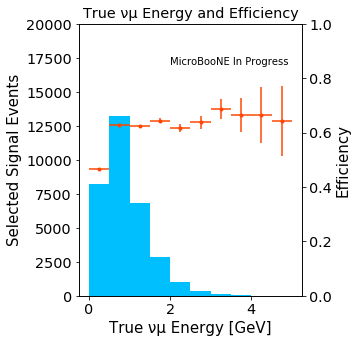

In [33]:
SEL_QUERY += ' and n_protons_tot > 0 '

selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

selCC = len(selected.query(fiduc_q))
totCC = len(mc.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(mc.query(SEL_QUERY)) * 0.08559738414394057
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057    #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.08442202570650682   #check this one!!
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

In [31]:
"""overlap_list = [590, 2000, 2680, 3462, 3497, 4256, 5493, 6685, 6758, 7258, 7288, 7880, 8846, 8908, 10409, 11348, 11364, 11852, 12220, 12946, 14608, 15392, 15546, 15948, 16523, 17762, 18098, 18313, 18438, 18447, 18808, 19139, 19466, 19687, 19894, 20772, 20970, 21405, 22301, 22534, 23201, 23301, 23450, 23467, 23489, 23710, 23790, 25500, 25850, 26643, 27859, 27948, 28578, 29334, 30148, 30250, 30369, 30504, 30630, 31077, 31609, 33044, 33422, 33973, 34864, 35141, 35212, 35540, 35745, 36318, 36583, 36615, 37003, 37736, 38596, 39289, 39699, 40243, 40674, 40890, 41018, 41399, 42735, 43188, 43299, 43302, 43786, 43922, 44150, 44475, 44975, 46200, 46324, 46911, 47233, 48502, 49584, 49769, 49804, 51322, 51979, 52183, 52365, 53359, 55214, 56421, 56593, 56958, 58356, 58477, 61415, 62899, 63167, 63852, 64887, 65304, 66603, 66676, 67869, 68165, 69003, 69693, 70419, 70582, 71640, 72065, 72086, 72293, 73106, 73944, 74433, 75756, 76092, 76747, 78072, 78409, 78823, 80575, 80855, 81005, 81929, 81977, 83183, 84027, 84097, 84185, 84850, 85355, 85455, 85815, 85871, 86604, 87249, 88329, 88717, 89528, 89661, 90340, 91421, 91780, 92022, 92216, 93197, 93663, 94155, 94536, 95864, 96944, 97560, 97901, 98181, 100062, 102022, 102043, 102179, 102983, 103605, 104483, 104972, 105246, 106536, 107074, 107112, 107687, 108965, 109277, 109337, 109692, 112459, 113496, 114722, 114847, 115871, 116025, 117210, 117394, 118306, 119872, 121226, 121378, 121913, 122882, 122936, 123600, 123788, 124169, 124820, 124944, 125226, 125354, 125425, 125544, 126733, 127424]

datasetlist = [mc]
#datasetlist = [mc, nue, dirt, ext, data]
count = 0

#print(nue['shr_score'].size)
#print(mc['shr_score'].size)

#we only care about the overlap value in the nue and mc part, so the rest can be 0s
overlap_df = [0]*(mc['n_protons_tot'].size)
overlapnue_df = [0]*(nue['n_protons_tot'].size)
overlapdirt_df = [0]*(dirt['n_protons_tot'].size)
overlapext_df = [0]*(ext['n_protons_tot'].size)
overlapdata_df = [0]*(data['n_protons_tot'].size)

#MC   
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['n_protons_tot'].size):
            if df.index[i] == j:
                count = count + 1
                overlap_df[i] = 1                

                
print(count)
print(len(overlap_df))

#nue
datasetlist = [nue]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['n_protons_tot'].size):
            if df.index[i] == j:
                count = count + 1
                overlapnue_df[i] = 1  
                
#dirt
datasetlist = [dirt]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['n_protons_tot'].size):
            if df.index[i] == j:
                count = count + 1
                overlapdirt_df[i] = 1  

                
#dirt
datasetlist = [ext]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['n_protons_tot'].size):
            if df.index[i] == j:
                count = count + 1
                overlapext_df[i] = 1    
                
#dirt
datasetlist = [data]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['n_protons_tot'].size):
            if df.index[i] == j:
                count = count + 1
                overlapdata_df[i] = 1"""

214
914729


In [32]:
"""mc['overlap'] = overlap_df
nue['overlap'] = overlapnue_df
dirt['overlap'] = overlapdirt_df
ext['overlap'] = overlapext_df
data['overlap'] = overlapdata_df"""

/tmp/ipykernel_3964/1237515314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nue['overlap'] = overlapnue_df


In [44]:
"""#Save the DataFrame to a csv file to check for any crossover in datapoints
#SEL_QUERY += ' and overlap == 0'
selected = nue.query(SEL_QUERY)
#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 14 and ccnc == 0) and nproton > 0"
selected_fid = selected
selected_fid.to_csv('numu_nuedf.csv')"""

'#Save the DataFrame to a csv file to check for any crossover in datapoints\n#SEL_QUERY += \' and overlap == 0\'\nselected = nue.query(SEL_QUERY)\n#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < # 254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 14 and ccnc == 0) and nproton > 0"\nselected_fid = selected\nselected_fid.to_csv(\'numu_nuedf.csv\')'

## Purity and Efficiency

Selection Efficiency = no. reconstructed neutrinos classified as numu CC that pass selection / total number of these simulated in the fiducial volume.

Selection Purity = no. reconstructed neutrinos classified as numu CC that pass selection / total number of selected neutrinos in any classification.

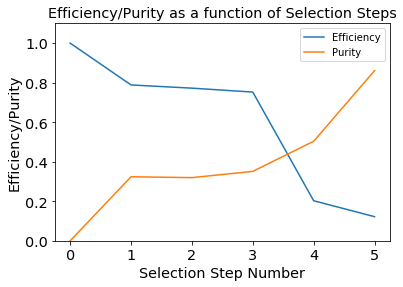

In [34]:
#make an efficiency/purity plot for each of the selection steps

plt.plot(effs)
plt.plot(purs)
plt.title("Efficiency/Purity as a function of Selection Steps")
plt.xlabel("Selection Step Number")
plt.ylabel("Efficiency/Purity")
plt.ylim([0,1.1])
plt.legend(["Efficiency", "Purity"])
plt.show()

In [48]:
"""#Now check on a variable

import matplotlib.pyplot as plt
import matplotlib

VARIABLE, BINS, RANGE, XTIT = 'muon_Angle_Numi_Theta',20,(-0.0,1),"cos Beta"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = systematicsBool, 
    draw_geoSys = False, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, NuMu - cos Beta',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()"""

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0  and n_protons_tot > 0  and n_protons_tot > 0  and n_protons_tot > 0 & muon_Angle_Numi_Theta <= 1 & muon_Angle_Numi_Theta >= -0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


UndefinedVariableError: name 'muon_Angle_Numi_Theta' is not defined

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0  and n_protons_tot > 0  and n_protons_tot > 0  and n_protons_tot > 0  and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < 254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 14 and ccnc == 0) and nproton > 0 & reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  0.33342651860212286  c  31
order w sum  2.1351930302802837  c  3
order w sum  15.07395136371953  c  5
order w sum  260.24933710045326  c  21
order w sum  1486.2167665773147  c  2
[0.    0.206 0.061 0.066 0.    0.    0.    0.    0.    0.   ]
sum:  0.3334265186021229
[1.096 1.006 0.301 0.066 0.    0.    0.    

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/NuMI/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc

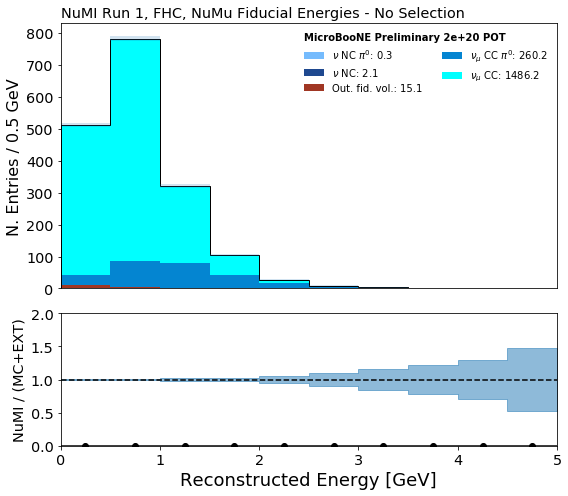

In [49]:
import matplotlib.pyplot as plt
import matplotlib

systematicsBool = False

SEL_QUERYB =SEL_QUERY + ' and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < 254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 14 and ccnc == 0) and nproton > 0 '

#why is this not just nu_e?
VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

#in the fiducial volume
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 14 and ccnc == 0)"
#FID_QUERY = fiduc

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERYB,
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = False,           #False as plotting MC
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]


ax1.set_title('NuMI Run 1, FHC, NuMu Fiducial Energies - No Selection',loc='left')
#ax2.set_ylim(0.95,1.05)

fig.tight_layout()

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 & reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  41.71783549274028  c  31
order w sum  115.01868305157642  c  5
order w sum  148.4358019898122  c  3
order w sum  306.95710655966104  c  21
order w sum  1722.3299239184946  c  2
order w sum  18.14522187163038  c  1
order w sum  0  c  12
order w sum  0.356587345429631  c  10
order w sum  10.20955674493298  c  11
total  2702.1408067689663

SUMS
[41.71783549274028, 156.73651854431662, 305.1723205341285, 612.1294270937906, 2334.4593510122863, 2352.6045728839167, 2352.6045728839167, 2352.961160229346, 2363.1707169742795]
[115.01868305157635, 148.4358019898119, 306.95710655966207, 172

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


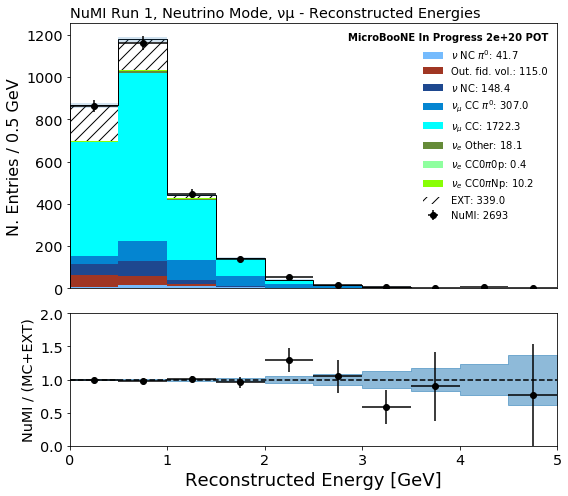

In [35]:
#Now check on a variable


import matplotlib.pyplot as plt
import matplotlib

VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, νμ - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

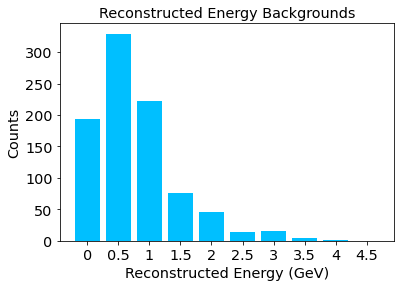

In [36]:
"""#NEEDED? IF SO, UPDATE

#Background numbers plot

bkg_nums = [194.2, 329.3, 221.9, 75.7, 45.3, 14.4, 16.2, 4.8, 1.2, 0.2]

import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 5, 0.5)
names = ['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5']
#gen = plt.hist(bkg_nums, bins, color='orange')
plt.bar(names, bkg_nums, color='deepskyblue')
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Counts")
plt.title("Reconstructed Energy Backgrounds")
plt.show()"""

In [54]:
##################################################################

In [42]:
def plot_signal_and_eff_and_B(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['neutrino_energy'], bins, color='deepskyblue')
    plt.close()
    print("Full numbers = ", gen[0])
    
    #This should give selected numbers in bin
    #print(selected['neutrino_energy'])
    #This should be the total numbers in bin
    #print(df.query(signal)['neutrino_energy'])
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['neutrino_energy'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True νμ Energy [GeV]', fontsize=15)

    # compute efficiency
    sel = ax1.hist(selected['neutrino_energy'], bins, color='white')
    print("Selected numbers = ", sel[0])
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['neutrino_energy'], bins, color='deepskyblue')
    ax1.set_ylim(0, 20000)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True νμ Energy and Efficiency") 
    plt.text(0, 0.95, r'MicroBooNE In Progress', fontweight='bold')

    plt.show()

In [36]:
def plot_signal_and_eff_alex(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin
    nue_truth = [1220.0367213238023, 2258.2406838876914, 2100.1833549260464, 1469.8593893372008, 673.8832816172271, 320.2300722027785, 201.54109350329145, 129.43528649905602, 81.12543212207311, 53.80879617018218]
    count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
    weights = [0.1*nue_truth[0], 0.6*nue_truth[1], 1.1*nue_truth[2], 1.6*nue_truth[3], 2.1*nue_truth[4], 2.6*nue_truth[5], 3.1*nue_truth[6], 3.6*nue_truth[7], 4.1*nue_truth[8], 4.6*nue_truth[9]]   
    
    gen = plt.hist(count, bins, color='deepskyblue', weights=nue_truth)
    #gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
    plt.close()
    print(gen)
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    #sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True νμ Energy [GeV]', fontsize=15)

    # compute efficiency
    #Use nu_e post selection numbers so in true bins of e
    nue_truth_reco = [248.55713594815757, 681.0584614749923, 356.4654864427089, 206.1349597325716, 88.39261579141157, 46.693414095384696, 30.45593839379694, 18.66783834062153, 14.378774753706463, 9.530986743937547]
    count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]

    weights = [0.1*nue_truth_reco[0], 0.6*nue_truth_reco[1], 1.1*nue_truth_reco[2], 1.6*nue_truth_reco[3], 2.1*nue_truth_reco[4], 2.6*nue_truth_reco[5], 3.1*nue_truth_reco[6], 3.6*nue_truth_reco[7], 4.1*nue_truth_reco[8], 4.6*nue_truth_reco[9]]

    sel = ax1.hist(count, bins, color='white', weights=nue_truth_reco)
    print(sel)
    #sel = ax1.hist(selected['nu_e'], bins, color='white')
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    #sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    sel = ax1.hist(count, bins, color='deepskyblue', weights=nue_truth_reco)
    ax1.set_ylim(0, 700)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True νμ Energy and Efficiency")
    plt.text(1.5, 0.95, r'MicroBooNE In Progress', fontweight='bold')

    plt.show()

(array([1220.037, 2258.241, 2100.183, 1469.859,  673.883,  320.23 ,
        201.541,  129.435,   81.125,   53.809]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]), <a list of 10 Patch objects>)
(array([248.557, 681.058, 356.465, 206.135,  88.393,  46.693,  30.456,
        18.668,  14.379,   9.531]), array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]), <a list of 10 Patch objects>)
In bin 0 , eff =  0.20372922519779596  with error =  0.011531096421209436
In bin 1 , eff =  0.30158807532530635  with error =  0.009657790763657404
In bin 2 , eff =  0.1697306502342321  with error =  0.008191454708371985
In bin 3 , eff =  0.1402412783344694  with error =  0.00905708264149822
In bin 4 , eff =  0.13116902912219675  with error =  0.013004419115420765
In bin 5 , eff =  0.14581208371279117  with error =  0.019721612131180403
In bin 6 , eff =  0.15111527810232683  with error =  0.025228808527029734
In bin 7 , eff =  0.1442252638020597  with error =  0.03087977000208048
I

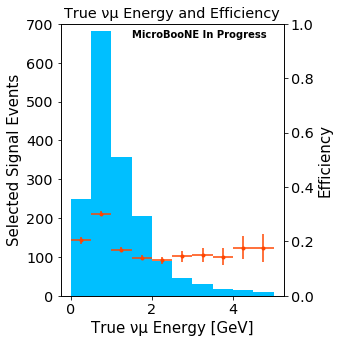

In [37]:
selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

bins = np.arange(0, 5.5, 0.5)
plot_signal_and_eff_alex(selected_fid, mc, fiduc_q, bins, mc.query(fiduc_q))

### Smearing Matrix Work

In [42]:
# plot the smearing matrix 
#Havse switched this to do UNSMEARING by swapping reco/true names
def plot_smearing(selected, signal, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1): 
                norm_array[i][j] =  norm_array[i][j] / tot_reco_events
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of True Events in Reco Bin', fontsize=15)

    plt.xlabel('Reco ν Energy [GeV]', fontsize=15)
    plt.ylabel('True ν Energy [GeV]', fontsize=15)
    plt.text(3.1, 1.0, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

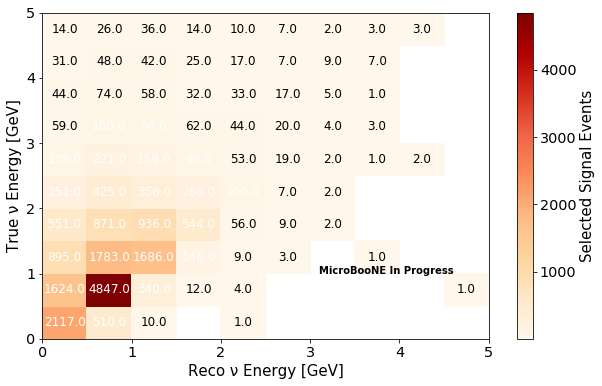

In [43]:
#swapped reco and true for UNSMEARING

# true nu energy 
true_var = 'reco_e'

# reconstructed nu energy 
reco_var = 'nu_e'

bins = np.arange(0, 5.5, 0.5)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins)

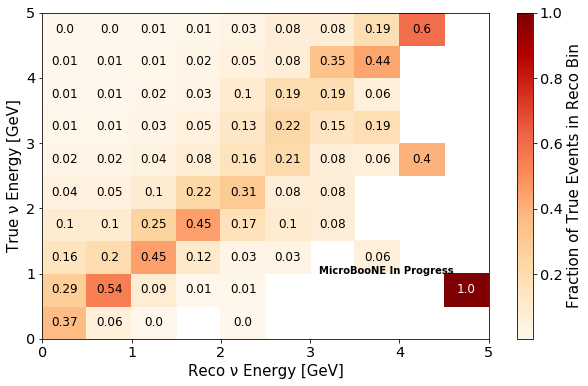

In [44]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins, norm=True)

In [45]:
# Calculate true numbers
#bkg_nums = [194.2, 329.3, 221.9, 75.7, 45.3, 14.4, 16.2, 4.8, 1.2, 0.2]
#n_data = [862, 1160, 447, 138, 53, 17, 5, 3, 7, 1]

n_selected = [539.0973436589838, 796.270478816479, 286.386248253036, 77.92390136828318, 16.245590428199876, 4.505157496723996, 1.3002802287990107, 0.3887615991932307, 0.2121620687973973, 0.0]

#UNSmearing, reco->true
true0 = (n_selected[0]*0.37) + (n_selected[1]*0.06)
true05 = (n_selected[0]*0.29) + (n_selected[1]*0.54) + (n_selected[2]*0.09) + (n_selected[3]*0.01) + (n_selected[4]*0.01) + (n_selected[9]*1.0)
true1 = (n_selected[0]*0.16) + (n_selected[1]*0.2) + (n_selected[2]*0.45) + (n_selected[3]*0.12) + (n_selected[4]*0.03) + (n_selected[5]*0.03) + (n_selected[7]*0.06)
true15 = (n_selected[0]*0.1) + (n_selected[1]*0.1) + (n_selected[2]*0.25) + (n_selected[3]*0.45) + (n_selected[4]*0.17) + (n_selected[5]*0.1) + (n_selected[6]*0.08)
true2 = (n_selected[0]*0.04) + (n_selected[1]*0.05) + (n_selected[2]*0.1) + (n_selected[3]*0.22) + (n_selected[4]*0.31) + (n_selected[5]*0.08) + (n_selected[6]*0.08)
true25 = (n_selected[0]*0.02) + (n_selected[1]*0.02) + (n_selected[2]*0.04) + (n_selected[3]*0.08) + (n_selected[4]*0.16) + (n_selected[5]*0.21) + (n_selected[6]*0.08) + (n_selected[7]*0.06) + (n_selected[8]*0.4)
true3 = (n_selected[0]*0.01) + (n_selected[1]*0.01) + (n_selected[2]*0.03) + (n_selected[3]*0.05) + (n_selected[4]*0.13) + (n_selected[5]*0.22) + (n_selected[6]*0.15) + (n_selected[7]*0.19)
true35 = (n_selected[0]*0.01) + (n_selected[1]*0.01) + (n_selected[2]*0.02) + (n_selected[3]*0.03) + (n_selected[4]*0.1) + (n_selected[5]*0.19) + (n_selected[6]*0.19) + (n_selected[7]*0.06)
true4 = (n_selected[0]*0.01) + (n_selected[1]*0.01) + (n_selected[2]*0.01) + (n_selected[3]*0.02) + (n_selected[4]*0.05) + (n_selected[5]*0.08) + (n_selected[6]*0.35) + (n_selected[7]*0.44)
true45 = (n_selected[2]*0.01) + (n_selected[3]*0.01) + (n_selected[4]*0.03) + (n_selected[5]*0.08) + (n_selected[6]*0.08) + (n_selected[7]*0.19) + (n_selected[8]*0.6)

#Smearing, true->reco
#true0 = (n_selected[0]*0.8) + (n_selected[1]*0.19)
#true05 = (n_selected[0]*0.24) + (n_selected[1]*0.71) + (n_selected[2]*0.05)
#true1 = (n_selected[0]*0.2) + (n_selected[1]*0.39) + (n_selected[2]*0.37) + (n_selected[3]*0.03)
#true15 = (n_selected[0]*0.19) + (n_selected[1]*0.29) + (n_selected[2]*0.32) + (n_selected[3]*0.18) + (n_selected[4]*0.02)
#true2 = (n_selected[0]*0.18) + (n_selected[1]*0.3) + (n_selected[2]*0.25) + (n_selected[3]*0.19) + (n_selected[4]*0.07)
#true25 = (n_selected[0]*0.16) + (n_selected[1]*0.33) + (n_selected[2]*0.24) + (n_selected[3]*0.15) + (n_selected[4]*0.08) + (n_selected[5]*0.03)
#true3 = (n_selected[0]*0.15) + (n_selected[1]*0.26) + (n_selected[2]*0.24) + (n_selected[3]*0.16) + (n_selected[4]*0.11) + (n_selected[5]*0.05) + (n_selected[6]*0.01)+ (n_selected[7]*0.01)
#true35 = (n_selected[0]*0.17) + (n_selected[1]*0.28) + (n_selected[2]*0.22) + (n_selected[3]*0.12) + (n_selected[4]*0.12) + (n_selected[5]*0.06) + (n_selected[6]*0.02)
#true4 = (n_selected[0]*0.17) + (n_selected[1]*0.26) + (n_selected[2]*0.23) + (n_selected[3]*0.13) + (n_selected[4]*0.09) + (n_selected[5]*0.04) + (n_selected[6]*0.05) + (n_selected[7]*0.04)
#true45 = (n_selected[0]*0.12) + (n_selected[1]*0.23) + (n_selected[2]*0.31) + (n_selected[3]*0.12) + (n_selected[4]*0.09) + (n_selected[5]*0.06) + (n_selected[6]*0.02) + (n_selected[7]*0.03) + (n_selected[8]*0.03)

In [46]:
#multiply by efficiency and sum

#eff = [0.46576510721247566, 0.6294446966258133, 0.624070021881838, 0.6444055944055944, 0.617704280155642, 0.637883008356546, 0.6883116883116883, 0.6666666666666666, 0.6666666666666666, 1.0]

#weighted eff
eff = [0.20372922519779596, 0.30158807532530635, 0.1697306502342321, 0.1402412783344694, 0.13116902912219675, 0.14581208371279117, 0.15111527810232683, 0.1442252638020597, 0.1772412716652168, 0.17712692760852147]

truths = [true0, true05, true1, true15, true2, true25, true3, true35, true4, true45]
ratio_nums = []

for i in range(len(truths)):
    num = truths[i]*(1/eff[i])
    ratio_nums.append(num)
    
print("truth, post sm no eff = ", truths)    
print("")    
print("Numbers of Ratio, numu: ", ratio_nums)
print("Ratio number, numu: ", sum(ratio_nums))


truth, post sm no eff =  [247.24224588281277, 613.0407454827421, 384.3801987604927, 243.515388467303, 112.659868864293, 48.15430897369184, 29.21342888387169, 24.1700381374848, 19.57486403952324, 4.7960661722261815]

Numbers of Ratio, numu:  [1213.5826150753335, 2032.7088357903044, 2264.648124720193, 1736.403085876965, 858.8907733649484, 330.24909697156716, 193.31883083383525, 167.58532798148798, 110.44190698708897, 27.07700199501143]
Ratio number, numu:  8934.905599596736


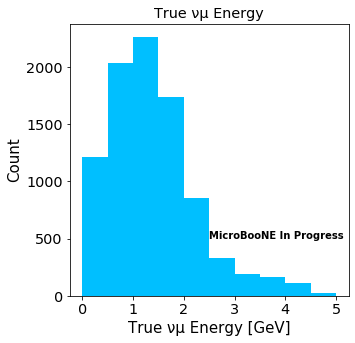

In [47]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

#nue_truth = [1250.7791092142888, 1126.4765890497615, 843.9206593785316, 681.7782953189057, 685.5350914033968, 675.4858086753779, 539.1810416459871, 583.8058667644001, 564.5980366563023, 347.7409423924605]

#SMEAR
#nums post sm no eff
#nue_truth = [582.5692659023181, 709.054714850508, 526.6655843648954, 439.3417476478123, 423.4579601567675, 430.88091974000434, 371.12461308100416, 389.20391117626673, 376.39869110420153, 347.7409423924605]
#post selection, yes eff
#nue_truth = [2859.527224612547, 2351.0701279740256, 3102.94919413839, 3132.7562959031306, 3228.3379925170834, 2955.042605307792, 2455.9039809972046, 2698.5834583767873, 2123.6514924986795, 1963.2302501233632]

#UNSMEAR
#nums post sm no eff
#nue_truth = [247.24224588281277, 613.0407454827421, 384.3801987604927, 243.515388467303, 112.659868864293, 48.15430897369184, 29.21342888387169, 24.1700381374848, 19.57486403952324, 4.7960661722261815]
#post selection, yes eff
nue_truth = [1213.5826150753335, 2032.7088357903044, 2264.648124720193, 1736.403085876965, 858.8907733649484, 330.24909697156716, 193.31883083383525, 167.58532798148798, 110.44190698708897, 27.07700199501143]


count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
weights = [0.1*nue_truth[0], 0.6*nue_truth[1], 1.1*nue_truth[2], 1.6*nue_truth[3], 2.1*nue_truth[4], 2.6*nue_truth[5], 3.1*nue_truth[6], 3.6*nue_truth[7], 4.1*nue_truth[8], 4.6*nue_truth[9]]
bins = np.arange(0, 5.5, 0.5)    
    
# plot selected signal events 
fig, ax1 = plt.subplots(figsize=(5, 5))
    
sel = ax1.hist(count, bins, color='deepskyblue', weights=nue_truth)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('True νμ Energy [GeV]', fontsize=15)
#ax1.set_ylim(0, 3500)
ax1.set_title("True νμ Energy")
    
plt.text(2.5, 500, r'MicroBooNE In Progress', fontweight='bold')
plt.show()

In [1]:
numu_ratio_nums = [1213.5826150753335, 2032.7088357903044, 2264.648124720193, 1736.403085876965, 858.8907733649484, 330.24909697156716, 193.31883083383525, 167.58532798148798, 110.44190698708897, 27.07700199501143]
nue_ratio_nums = [38.31639261211691, 144.96600182001526, 107.50580641501391, 44.83461606029701, 17.806099366133466, 9.199172945976592, 4.958849989093653, 2.0338586530528717, 1.5850253907811056, 0.826600465296638]
bin_ratios = []

for i in range(len(numu_ratio_nums)):
    ratio = nue_ratio_nums[i]/numu_ratio_nums[i]
    bin_ratios.append(ratio)
    
print(bin_ratios)

[0.031572957733691995, 0.07131665847443094, 0.047471307017418744, 0.02582039644190878, 0.02073150616855857, 0.027855255412760738, 0.02565114824926688, 0.01213625725801926, 0.014351666265291855, 0.03052776911745724]


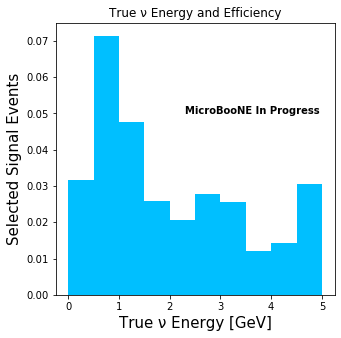

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
weights = [0.1*bin_ratios[0], 0.6*bin_ratios[1], 1.1*bin_ratios[2], 1.6*bin_ratios[3], 2.1*bin_ratios[4], 2.6*bin_ratios[5], 3.1*bin_ratios[6], 3.6*bin_ratios[7], 4.1*bin_ratios[8], 4.6*bin_ratios[9]]
    
bins = np.arange(0, 5.5, 0.5)    
# plot selected signal events 
fig, ax1 = plt.subplots(figsize=(5, 5))
    
sel = ax1.hist(count, bins, color='deepskyblue', weights=bin_ratios)
ax1.set_ylabel('Selected Signal Events', fontsize=15)
ax1.set_xlabel('True ν Energy [GeV]', fontsize=15)
#ax1.set_ylim(0, 3500)
ax1.set_title("True ν Energy and Efficiency")
    
plt.text(2.3, 0.05, r'MicroBooNE In Progress', fontweight='bold')
plt.show()